Iter-001 | Jacc 19.16% | best 19.16%
Iter-002 | Jacc 19.12% | best 19.16%
Iter-003 | Jacc 17.62% | best 19.16%
Iter-004 | Jacc 18.61% | best 19.16%
Iter-005 | Jacc 19.12% | best 19.16%
Iter-006 | Jacc 19.06% | best 19.16%
Iter-007 | Jacc 18.21% | best 19.16%
Iter-008 | Jacc 19.03% | best 19.16%
Iter-009 | Jacc 18.71% | best 19.16%
Iter-010 | Jacc 17.59% | best 19.16%
Iter-011 | Jacc 18.23% | best 19.16%
Iter-012 | Jacc 19.12% | best 19.16%
Iter-013 | Jacc 18.95% | best 19.16%
Iter-014 | Jacc 19.06% | best 19.16%
Iter-015 | Jacc 19.07% | best 19.16%
Iter-016 | Jacc 19.01% | best 19.16%
Iter-017 | Jacc 19.12% | best 19.16%
Iter-018 | Jacc 19.12% | best 19.16%
Iter-019 | Jacc 19.51% | best 19.51%
Iter-020 | Jacc 19.12% | best 19.51%
Iter-021 | Jacc 19.09% | best 19.51%
Iter-022 | Jacc 19.03% | best 19.51%
Iter-023 | Jacc 19.06% | best 19.51%
Iter-024 | Jacc 19.16% | best 19.51%
Iter-025 | Jacc 18.71% | best 19.51%

Final Jaccard Index (without leak): 44.21%



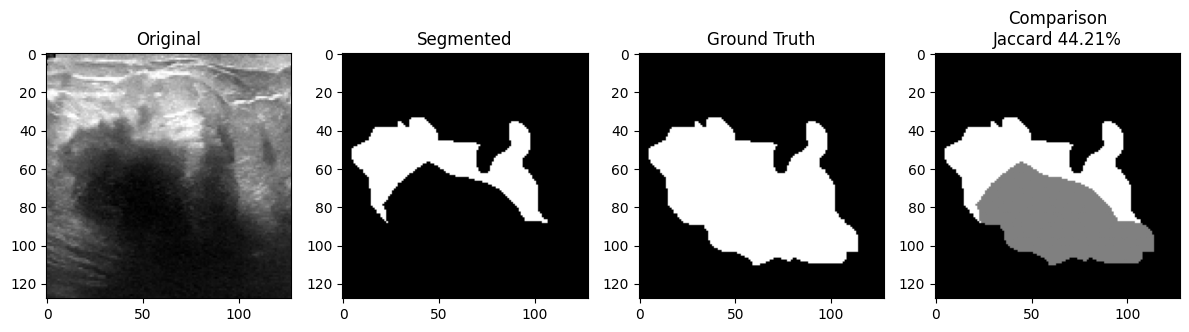

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, segmentation
from skimage.filters import threshold_otsu
import os
import random

OUTPUT_SIZE = (128, 128)
# ------------------ FUNGSI DASAR ------------------
def threshold(I):
    I = I.astype(np.uint8)
    hist, _ = np.histogram(I, bins=256, range=(0, 256))
    P = hist / np.sum(hist)
    w = np.cumsum(P)
    Mean = np.cumsum(P * np.arange(256))
    var = (Mean[-1] * w - Mean) ** 2 / (w * (1 - w))
    idx = np.mean(np.where(var == np.max(var)))
    return (idx - 1) / 255

def preprocess(I, gamma_value=0.1, contrast_alpha=1.2):
    alpha = np.max(I) - np.min(I)

    # Jika kontras gambar rendah, kita beri perhatian lebih pada bagian gelap
    if alpha <= 220:
        I_contrast = cv2.convertScaleAbs(I, alpha=contrast_alpha, beta=0)
        I_eq = cv2.equalizeHist(I_contrast)
    else:
        I_gamma = np.uint8(np.power(I / 170.0, gamma_value) * 170)
        I_median = cv2.medianBlur(I_gamma, 23)
        I_eq = cv2.equalizeHist(I_median)

    T = threshold_otsu(I_eq)
    I_bin = I_eq > T

    return I_bin

# Segmentasi
def region_growing(I, T, seed_threshold=0.07):
    I_eroded = morphology.erosion(I, morphology.disk(20))
    seeds    = morphology.skeletonize(I_eroded)
    seeds    = seeds[seeds > seed_threshold]
    regions  = np.zeros_like(I, dtype=bool)
    I_float  = I.astype(float)
    for s in seeds:
        regions |= (np.abs(I_float - s) <= T)
    return morphology.remove_small_objects(regions, min_size=100)

def postprocess(I, n=5):
    opened  = morphology.opening(I, morphology.disk(n))
    mask    = morphology.erosion(opened, morphology.disk(6))
    diff    = np.logical_xor(opened, mask)
    filled  = morphology.remove_small_holes(diff)
    return morphology.dilation(filled, morphology.disk(5))

def jaccard_coefficient(GT, seg):
    inter = np.logical_and(GT, seg).sum()
    union = np.logical_or(GT, seg).sum()
    return inter / union, 1 - inter / union

def display_results(img, seg, GT, jac):
    fig, ax = plt.subplots(1, 4, figsize=(12, 6))
    ax[0].imshow(img, cmap='gray');  ax[0].set_title('Original')
    ax[1].imshow(seg, cmap='gray');  ax[1].set_title('Segmented')
    ax[2].imshow(GT,  cmap='gray');  ax[2].set_title('Ground Truth')
    ax[3].imshow(np.abs(seg - GT), cmap='gray')
    ax[3].set_title(f'Comparison\nJaccard {jac*100:.2f}%')
    plt.tight_layout(); plt.show()

def save_results(seg, fname):
    os.makedirs('Segmentation_Results', exist_ok=True)
    cv2.imwrite(os.path.join('Segmentation_Results', f'lesion_{fname}'),
                seg.astype(np.uint8)*255)

def crop_segmented_area(seg, GT):

    seg[GT == 0] = 0
    return seg

# ------------------ PENINGKATAN SEGMENTASI DENGAN CHAN VESE------------------
def improve_segmentation(img_res, seg_init):

    seg = morphology.binary_closing(seg_init, morphology.disk(3))
    seg = morphology.remove_small_holes(seg, area_threshold=64)

    img_norm = img_res.astype(float) / img_res.max()
    seg_cv = segmentation.chan_vese(
        img_norm,
        mu=0.25,
        lambda1=1, lambda2=1,
        tol=1e-3,
        max_num_iter=100,
        init_level_set=seg.astype(float),
        extended_output=False
    )

    seg_cv = morphology.remove_small_holes(seg_cv, area_threshold=64)
    seg_cv = morphology.remove_small_objects(seg_cv, min_size=100)
    return seg_cv

# ------------------ JACCARD ------------------
def random_search(img_path, gt_path, target=0.80, max_iter=25):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    GT  = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
    img_res = cv2.resize(img, OUTPUT_SIZE)
    GT_res  = cv2.resize(GT,  OUTPUT_SIZE, interpolation=cv2.INTER_NEAREST)

    best_jac, best_par, best_n = 0, (0, 0), 10
    for i in range(1, max_iter+1):
        gamma = random.uniform(0.1, 2.0)
        alpha = random.uniform(1.0, 3.0)
        n     = random.choice([2, 4, 6, 8, 10])

        I_pre = preprocess(img_res, gamma_value=gamma, contrast_alpha=alpha)
        T     = threshold_otsu(I_pre)
        seg   = postprocess(region_growing(I_pre, T), n)
        jac   = jaccard_coefficient(GT_res, seg)[0]

        if jac > best_jac:
            best_jac, best_par, best_n = jac, (gamma, alpha), n

        print(f"Iter-{i:03} | Jacc {jac*100:5.2f}% | best {best_jac*100:5.2f}%")
        if jac >= target:
            break

    return best_par, best_n

# ------------------ PENJALANAN ------------------
def main(img_path, gt_path):
    (gamma, alpha), n = random_search(img_path, gt_path)

    # Ukuran Output
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    GT  = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
    img_res = cv2.resize(img, OUTPUT_SIZE)
    GT_res  = cv2.resize(GT,  OUTPUT_SIZE, interpolation=cv2.INTER_NEAREST)

    # Output Segmentasi
    I_pre = preprocess(img_res, gamma_value=gamma, contrast_alpha=alpha)
    T     = threshold_otsu(I_pre)
    seg   = postprocess(region_growing(I_pre, T), n)

    # Ground Truth
    seg = improve_segmentation(img_res, seg)

    seg = crop_segmented_area(seg, GT_res)

    jac, _ = jaccard_coefficient(GT_res, seg)
    print(f"\nFinal Jaccard Index (without leak): {jac*100:.2f}%\n")

    display_results(img_res, seg, GT_res, jac)
    save_results(seg, os.path.basename(img_path))

# ------------------ PEMANGGILAN ------------------
if __name__ == "__main__":
    img_path = "/content/malignant (23).png"
    gt_path  = "/content/malignant (23)_mask.png"
    main(img_path, gt_path)